# Company Bankruptcy Prediction 

Author: Mert Ertugrul

Status: In-progress

This notebook was prepared to work on the task "Company Bankruptcy Prediction" found at the following link: https://www.kaggle.com/fedesoriano/company-bankruptcy-prediction

Dataset description provided: "The data were collected from the Taiwan Economic Journal for the years 1999 to 2009. Company bankruptcy was defined based on the business regulations of the Taiwan Stock Exchange."

-Dataset includes 95 features, almost all are numerical. High dimensinality will be an important factor in model choice, feature selection and extraction.


In [21]:
#Imports
import sys, warnings
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from imblearn.combine import SMOTETomek

from sklearn import decomposition, tree
from sklearn.preprocessing import scale, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score,recall_score,precision_score,f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv("/content/drive/MyDrive/Data Projects/data.csv")

## General structure of the dataset

### Displaying the first few rows

In [6]:
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,...,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,...,0.182419,0.014948,0.004136,1.383910e-03,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,0.023947,0.931065,0.002226,0.025516,1.065198e-04,7.700000e+09,0.593916,2.490000e+09,0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,2.361297e-04,25500000.0,0.458521,0.000790,0.0,0.177911,0.177911,0.193713,0.180581,0.307102,0.005944,0.092338,0.142803,0.022760,0.848094,0.689463,0.689470,0.217601,7.280000e+09,0.000396,0.264184,0.368913,0.011543,0.005348,0.629631,0.021248,0.207516,0.792484,0.005100,..

### Looking for missing values

In [7]:
# get null values
null_values = df.isnull().sum().sum()
print('Null:', null_values)
# get nan values
nan_values = np.isnan(df.values).sum()
print('Nan:', nan_values)

Null: 0
Nan: 0


No missing values are present in the dataset.

### Displaying the feature names and types

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

We see that all features other than  "Net Income Flag" and "Liability-Assets Flag" are numerical. 

In [9]:
df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,...,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,1.995347e+09,1.950427e+09,0.467431,1.644801e+07,0.115001,0.190661,0.190633,0.190672,0.228813,0.323482,1.328641e+06,0.109091,0.184361,0.022408,0.847980,0.689146,0.689150,0.217639,5.508097e+09,1.566212e+06,0.264248,0.379677,4.032850e+05,8.376595e+06,0.630991,4.416337e+06,0.113177,0.886823,0.008783,...,0.522273,0.124095,3.592902e+06,3.715999e+07,0.090673,0.353828,0.277395,5.580680e+07,0.761599,0.735817,0.331410,5.416004e+07,0.934733,0.002549,0.029184,1.195856e+09,2.163735e+09,0.594006,2.471977e+09,0.671531,1.220121e+06,0.761599,0.331410,0.115645,0.649731,0.461849,0.593415,0.315582,0.031506,0.001173,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686


### Displaying the disributions of the features

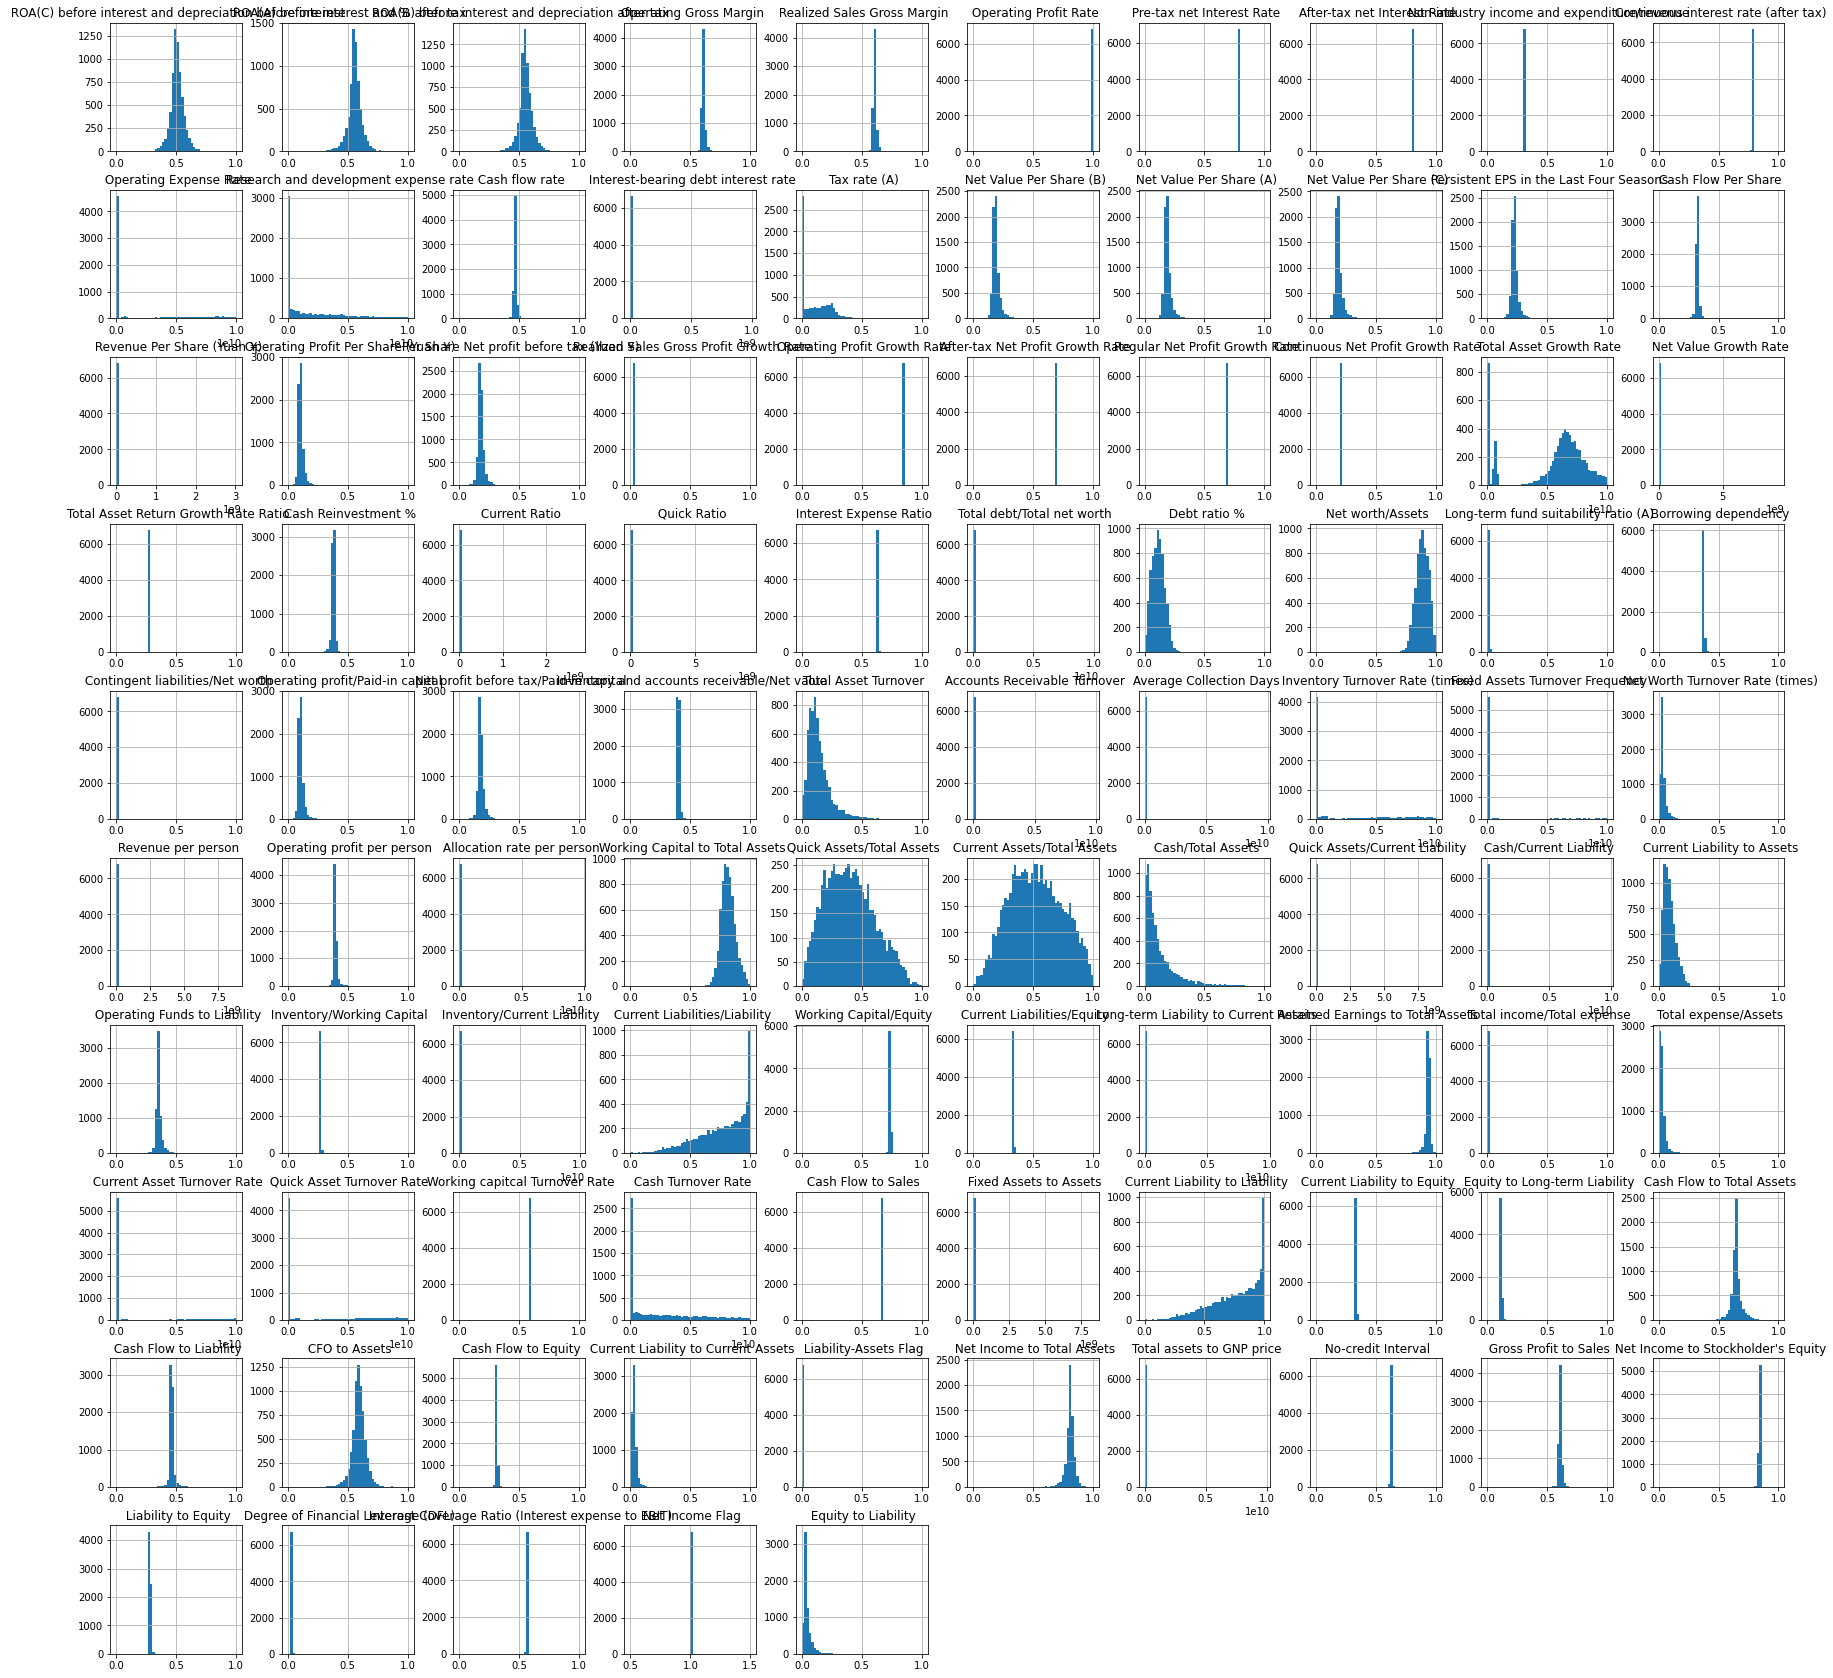

In [6]:
Y = df['Bankrupt?']
X = df.drop('Bankrupt?', axis=1)

X.hist(figsize = (30,30),bins = 50)
plt.show()

It is apparent that our features come in groups of different distributions, some resembling exponential, some more similar to normal and others, weibull distribution. We also know that most features are numerical and are on different scales. The two flag features (non-numerical) are inconsequential as all data points have the same value for them.

In addition to distributions, it helps to see box plots of some features to observe outliers.

In [11]:
# detecting outliers based on inter-quartile range

Q1=df.quantile(0.25)
Q3=df.quantile(0.75)
IQR=Q3-Q1
df_outliers=( (df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)) ).sum() / df.shape[0] * 100
print("Average percentage of outliers per feature:")
print( round(df_outliers.mean()), "%")

Average percentage of outliers per feature:
8 %


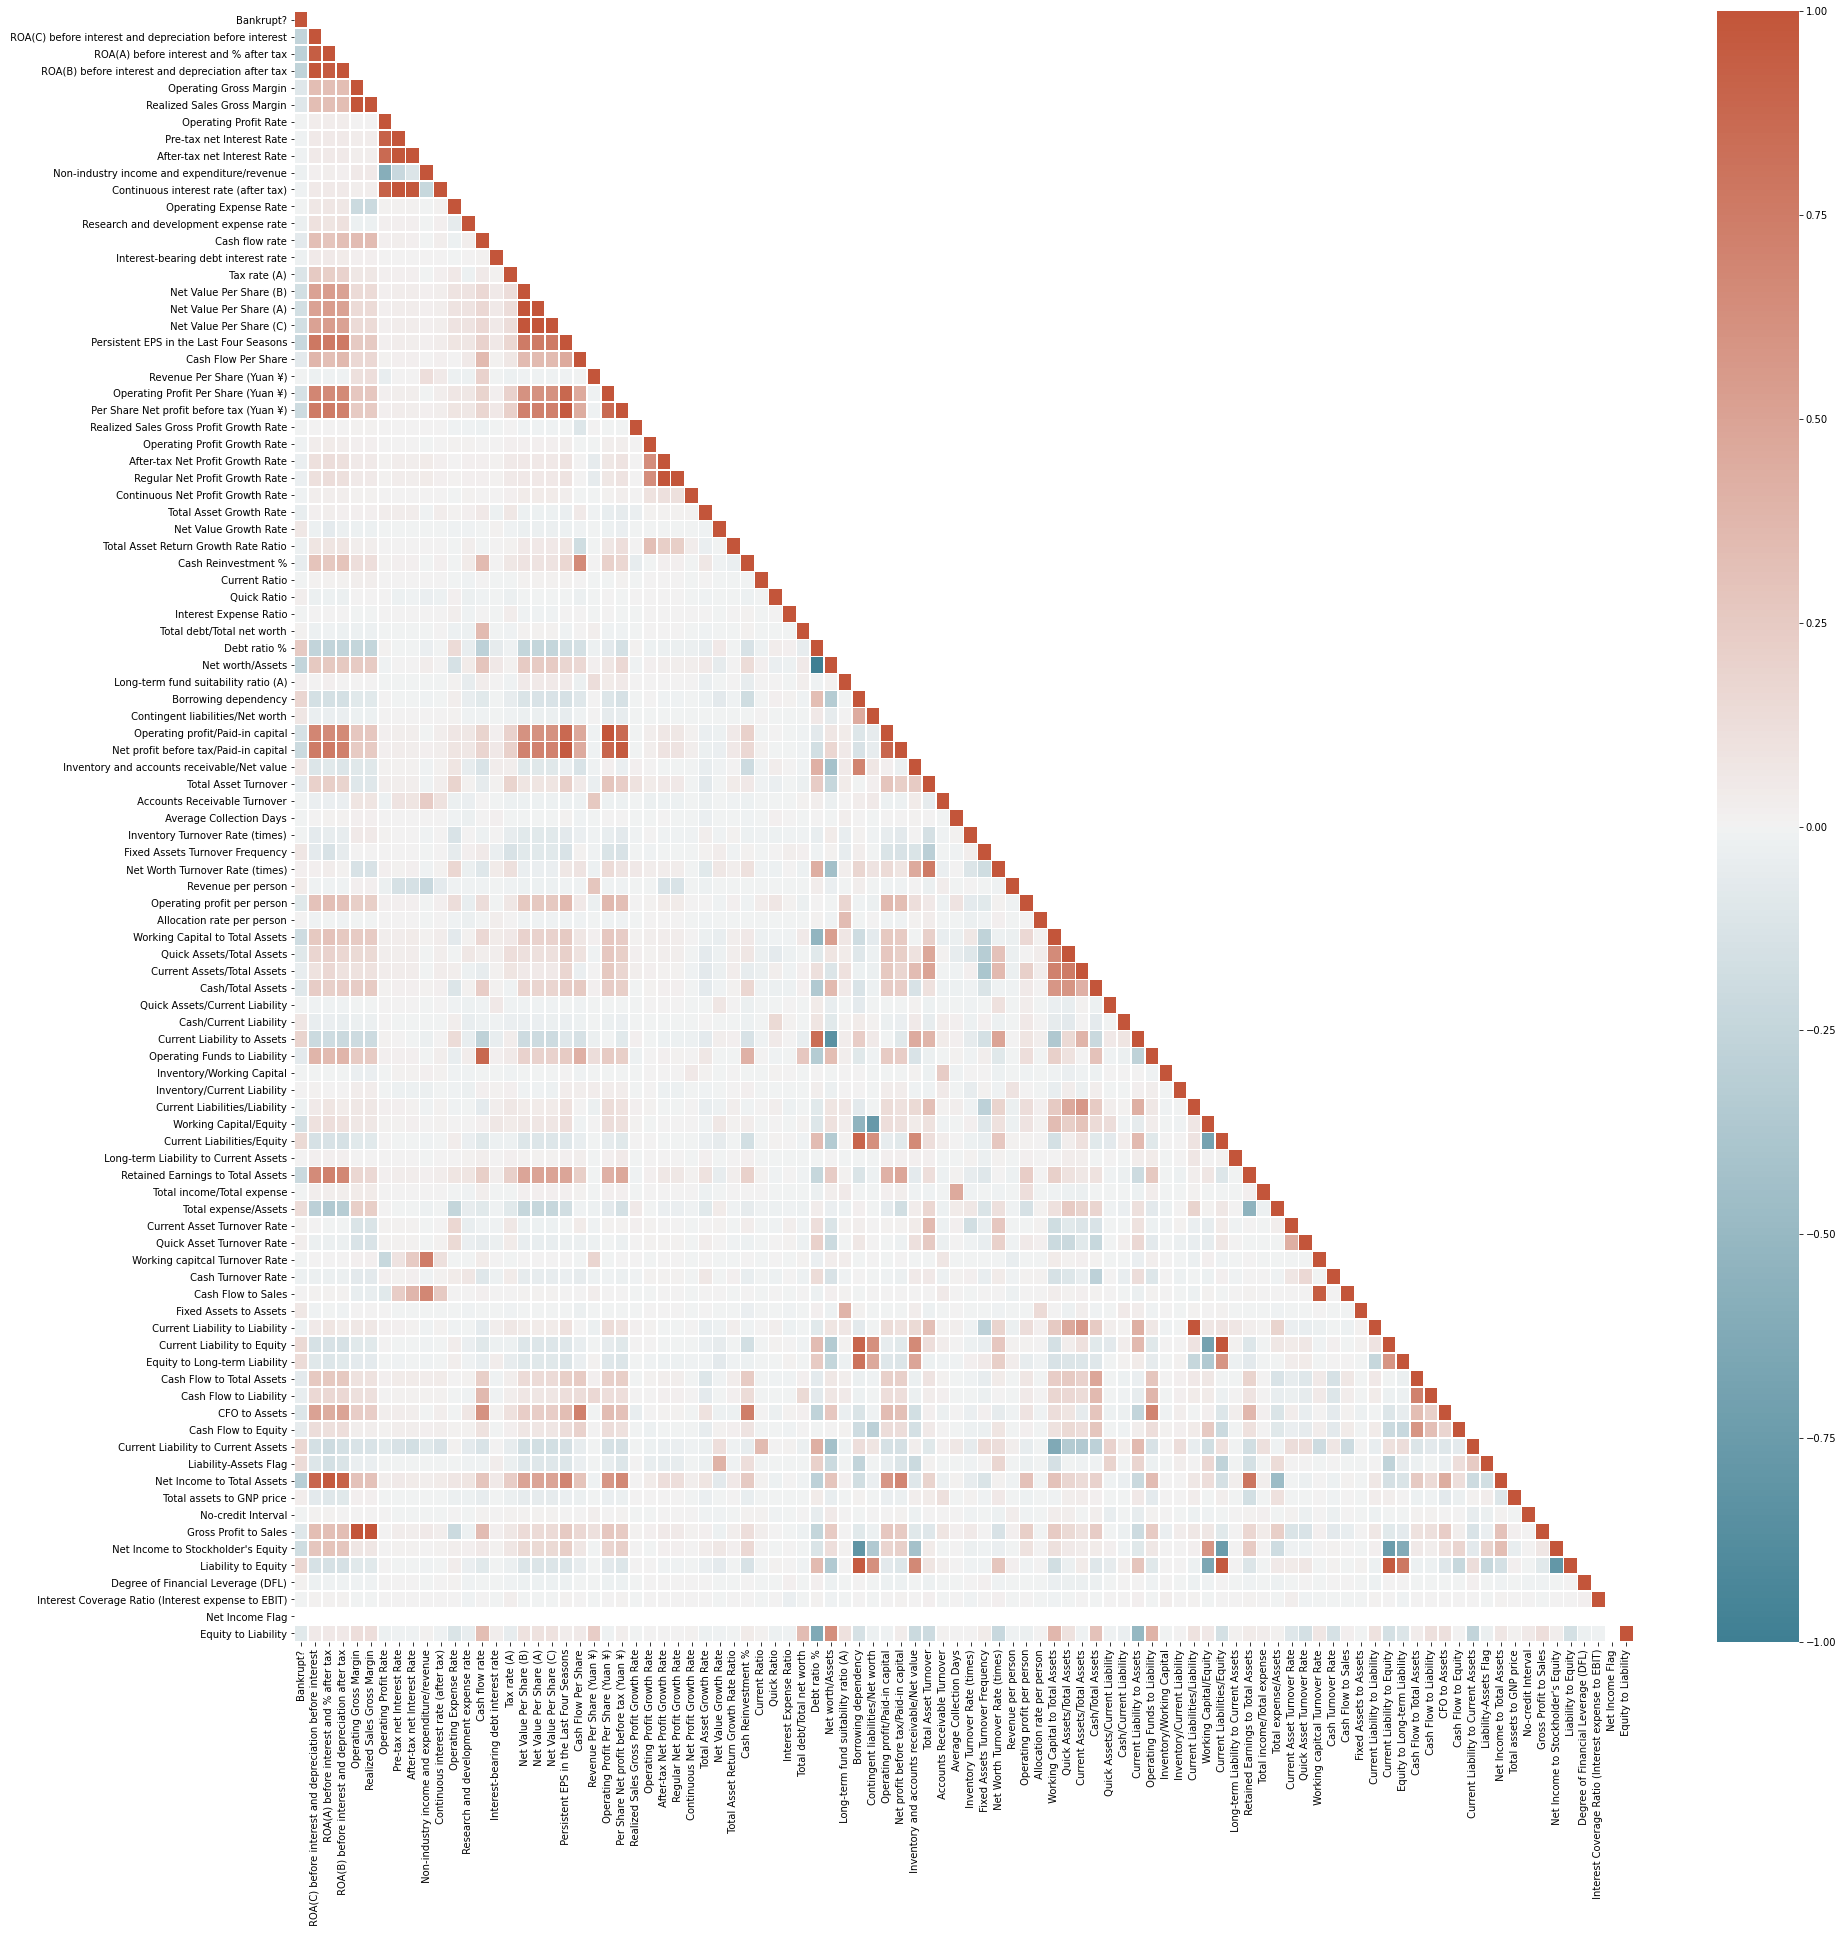

In [12]:
corr_mat = df.corr()
#lower trainglular part of the correlation matrix
lt_mat = corr_mat.where(np.tril(np.ones(corr_mat.shape)).astype(np.bool))

fig, ax = plt.subplots(figsize=(30,30))   

cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(lt_mat, linewidths=0.5,cmap=cmap, ax=ax)
plt.show()

One thing to point out is that there are groups of features that appear highly correlated with each other as well as the label. When we use a feauture selection method we will get a number of redundant features in the process as well.

In [13]:
print("Bankrupt?")
print("No   : " , df['Bankrupt?'].value_counts()[0] , " -> ", round( 100*df['Bankrupt?'].value_counts()[0]/len(df) ),"%" )
print("Yes  : " , df['Bankrupt?'].value_counts()[1] , "  -> ", round( 100*df['Bankrupt?'].value_counts()[1]/len(df) ),"%" )

Bankrupt?
No   :  6599  ->  97 %
Yes  :  220   ->  3 %


There are an number of decisions to be made on how to approach our data:

**1 - Feautures comprising our data are on different scales, should we transform the data to account for it?** 

  - We will standardize the data.
    
**2- Our data is drastically skewed with the positive label representing only 3% of data points. Then, should we include steps to balance our training dataset? If so, which methods should we use?** 

  - We will carry out the entire process first without and later with artificially balaced data. Then, we will compare the results.
    
**3- Our data is very high dimensional. Should we choose subsets of the available features?**

  - We will use ANOVA F measure to assign scores to each feature and select k features with the highest scores. We will train our models with a range of different k values and keep the best performing feature set.
  - We will also use PCA to extract features and repeat the process with k principle components, varying k.
    
 

In [7]:
from scipy import stats

def standardize(df):

    df_copy = df.copy()
    for column in df_copy.columns:

        if df_copy[column].std() == 0:
          df_copy = df_copy.drop(column, axis = 1)
          continue

        df_copy[column] = (df_copy[column] - df_copy[column].mean()) / df_copy[column].std()  
        
    return df_copy

def robust_scaling(df):

    df_copy = df.copy()
    
    for column in df_copy.columns:
        if df_copy[column].max() == df_copy[column].min():
            df_copy[column] = df_copy[column]/df_copy[column].min()
        else:
            quantile_diff = (df_copy[column].quantile(0.75) - df_copy[column].quantile(0.25))
            if quantile_diff != 0:
                df_copy[column] = (df_copy[column] - df_copy[column].median())  / (df_copy[column].quantile(0.75) - df_copy[column].quantile(0.25))
            else:
                df_copy[column] = (df_copy[column] - df_copy[column].median())  / df_copy[column].std() 
            
    return df_copy

### Robust Scaling

In [8]:
from sklearn import preprocessing

Y = df['Bankrupt?']
X = df.drop('Bankrupt?', axis=1)

x = X.values
y = Y.values

#scaler = RobustScaler()
#x_scaled = scaler.fit_transform(X)
#X_scaled = pd.DataFrame(x_scaled)

X_scaled =  standardize(X) 


#### Train-Test Split

In [9]:
#X_cv , Y_cv will be used for model and parameter selection with cross validation
X_cv_unclean,X_test,Y_cv_unclean,Y_test  = train_test_split(X_scaled, Y, test_size=0.1, stratify = Y, random_state = 42)

#### Removing Outliers
Training data points with an outlier value in at least one feature are removed to improve PCA and feature selection performance. 

In [10]:
#removing outliers
Y_cv = Y_cv_unclean[(np.abs(stats.zscore(X_cv_unclean)) < 10).all(axis=1)]
X_cv = X_cv_unclean[(np.abs(stats.zscore(X_cv_unclean)) < 10).all(axis=1)]

print("Cleaned X size: ", X_cv.shape)
print("Cleaned Y size: ", Y_cv.shape)

Cleaned X size:  (5901, 94)
Cleaned Y size:  (5901,)


Dataset size dropped from 6819 to 4399 and one constant feature was dropped.

#### Balancing the training set

A version of the training data resampled to increase the ratio of "Bankrupt? = 1" labelled data points will evaluated along with the original training set. A combination of over and under-sampling ( SMOTE + Tomek ) will be used.

In [11]:
smt = SMOTETomek(ratio=0.3)
X_smt, y_smt = smt.fit_sample(X_cv, Y_cv)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


### Extracing new featurs with PCA

Principle components will also be used as an alternative set of features.

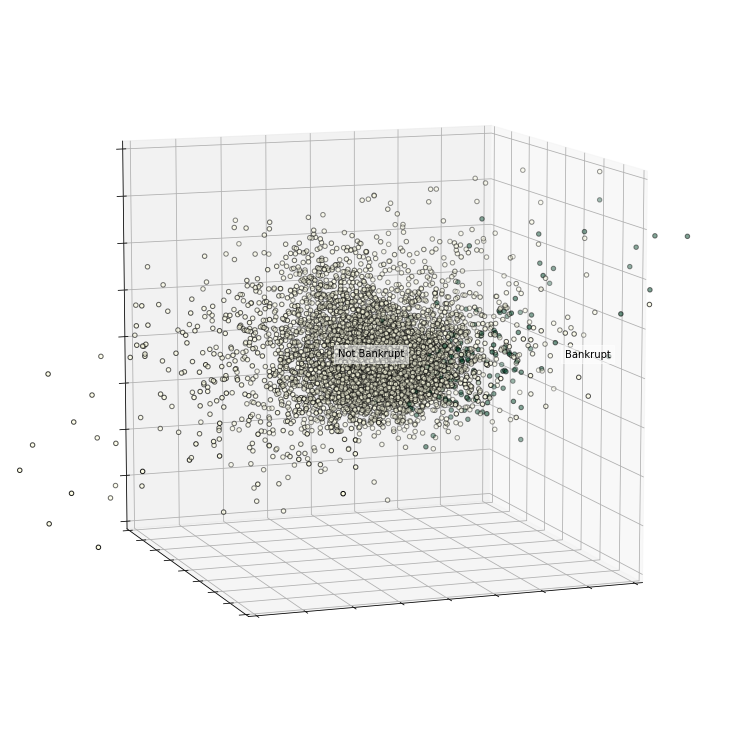

In [181]:
fig = plt.figure(1, figsize=(10, 10))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=10, azim=70, autoscale_on=True)

plt.cla()
pca = decomposition.PCA(n_components=60)
pca.fit(X_cv)
X_PCA = pca.transform(X_cv)

for name, label in [('Bankrupt', 1), ('Not Bankrupt', 0)]:
    ax.text3D(X_PCA[Y_cv == label, 0].mean()*2.2,
              X_PCA[Y_cv == label, 1].mean()*3,
              X_PCA[Y_cv == label, 2].mean()*2,
               name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))


ax.scatter(X_PCA[:, 0], X_PCA[:, 1], X_PCA[:, 2], c=Y_cv, cmap='YlGn',
           edgecolor='k')

ax.set_xlim(-10,10)

ax.set_ylim(-10,10)

ax.set_zlim(-10,10)


ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()

The first three principle components demonstrate visible a seperation between the two classes.

In [182]:
explained_variance = pca.explained_variance_ratio_
print('Explained variation per principal component: {}'.format(explained_variance))
    

explained_variance = np.insert(explained_variance, 0, 0)
cumulative_variance = np.cumsum(np.round(explained_variance, decimals=4)) 
      

Explained variation per principal component: [2.41704258e-01 1.15373818e-01 9.84109871e-02 5.35788587e-02
 4.19295988e-02 4.08020765e-02 3.39472831e-02 3.00647287e-02
 2.74292828e-02 2.52561194e-02 2.45627784e-02 2.31202539e-02
 2.20564948e-02 2.10478936e-02 2.01110404e-02 1.80147363e-02
 1.66731953e-02 1.45628702e-02 1.29187078e-02 1.12735951e-02
 1.07414844e-02 9.35631576e-03 6.73303677e-03 6.54428838e-03
 6.27457452e-03 6.24383271e-03 5.75922756e-03 4.39901306e-03
 3.93364401e-03 3.83734565e-03 3.78174062e-03 3.66563624e-03
 3.23016623e-03 2.99844587e-03 2.77618721e-03 2.70376099e-03
 2.38689423e-03 2.24643986e-03 2.03968434e-03 1.98067093e-03
 1.75843773e-03 1.61200604e-03 1.46314390e-03 1.31388220e-03
 9.86977877e-04 9.22364856e-04 8.95287733e-04 7.81511193e-04
 7.58833682e-04 5.82300186e-04 5.63654784e-04 4.66484956e-04
 4.09646048e-04 3.31261282e-04 2.97173696e-04 2.78754866e-04
 2.67113721e-04 2.21091449e-04 2.17275156e-04 2.01309752e-04]


In [183]:
pc_df = pd.DataFrame(['','PC1', 'PC2', 'PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10'], columns=['PC'])
explained_variance_df = pd.DataFrame(explained_variance, columns=['Explained Variance'])
cumulative_variance_df = pd.DataFrame(cumulative_variance, columns=['Cumulative Variance'])


df_explained_variance = pd.concat([pc_df, explained_variance_df[1:11], cumulative_variance_df[1:11]], axis=1)
df_explained_variance


,PC,Explained Variance,Cumulative Variance
0,,NaN,NaN
1,PC1,0.241704,0.2417
2,PC2,0.115374,0.3571
3,PC3,0.098411,0.4555
4,PC4,0.053579,0.5091
5,PC5,0.041930,0.5510
6,PC6,0.040802,0.5918
7,PC7,0.033947,0.6257
8,PC8,0.030065,0.6558
9,PC9,0.027429,0.6832


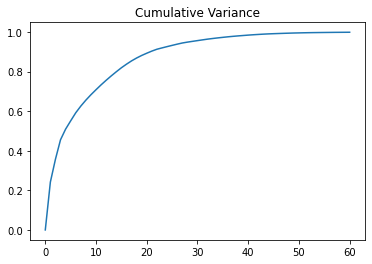

In [184]:
plt.plot(cumulative_variance)
plt.title("Cumulative Variance")
plt.show()

We see that approximately 10 to 15 principle components are needed to reach a cumulative explained variance of 80%. To identify the ideal number of components to use for classification, we will later evaluate our models with 5, 10, 15 and 20 principle components.

In previous iterations where we did not remove the outliers, more than 30 principal components were needed to reach the same cumulative explained variance. This shows how much the outliers hinder the feature quality.

Now we will compare the spread of the first 4 principle components to the spread of the 4 original highest ranked features according to ANOVA F measure.

In [186]:
#obtaining the original features for comparison
best_k = SelectKBest(score_func=f_classif , k=10)
fit = best_k.fit(X_cv, Y_cv)
X_k = best_k.fit_transform(X_cv, Y_cv)

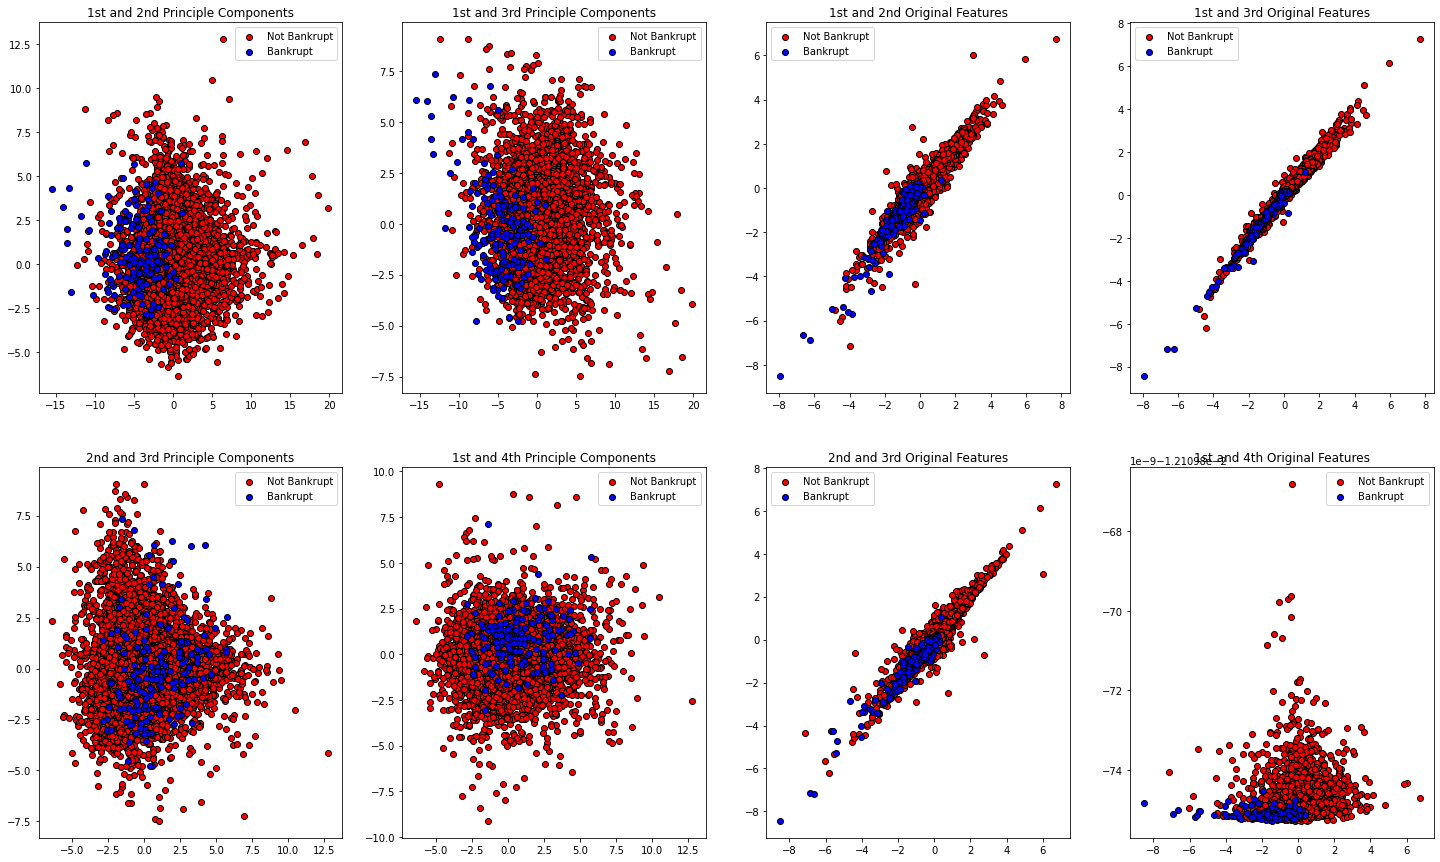

In [187]:
#creating plots
fig, ((ax1, ax2, ax5, ax6), (ax3, ax4, ax7, ax8)) = plt.subplots(2, 4,figsize=(25, 15))

# ------------------------ Principle Components -------------------------------------
ax1.scatter(X_PCA[Y_cv == 0, 0],X_PCA[Y_cv == 0, 1], color='r', label="Not Bankrupt",edgecolor='k')
ax1.scatter(X_PCA[Y_cv == 1,0],X_PCA[Y_cv == 1, 1], color='b', label="Bankrupt",edgecolor='k')
ax1.set_title("1st and 2nd Principle Components")
ax1.legend()

ax2.scatter(X_PCA[Y_cv == 0, 0],X_PCA[Y_cv == 0, 2], color='r', label="Not Bankrupt",edgecolor='k')
ax2.scatter(X_PCA[Y_cv == 1,0],X_PCA[Y_cv == 1, 2], color='b', label="Bankrupt",edgecolor='k')
ax2.set_title("1st and 3rd Principle Components")
ax2.legend()

ax3.scatter(X_PCA[Y_cv == 0, 1],X_PCA[Y_cv == 0, 2], color='r', label="Not Bankrupt",edgecolor='k')
ax3.scatter(X_PCA[Y_cv == 1,1],X_PCA[Y_cv == 1, 2], color='b', label="Bankrupt",edgecolor='k')
ax3.set_title("2nd and 3rd Principle Components")
ax3.legend()

ax4.scatter(X_PCA[Y_cv == 0, 1],X_PCA[Y_cv == 0, 3], color='r', label="Not Bankrupt",edgecolor='k')
ax4.scatter(X_PCA[Y_cv == 1,1],X_PCA[Y_cv == 1, 3], color='b', label="Bankrupt",edgecolor='k')
ax4.set_title("1st and 4th Principle Components")
ax4.legend()

# ------------------------ Original Features -------------------------------------
ax5.scatter(X_k[Y_cv == 0, 0],X_k[Y_cv == 0, 1], color='r', label="Not Bankrupt",edgecolor='k')
ax5.scatter(X_k[Y_cv == 1,0],X_k[Y_cv == 1, 1], color='b', label="Bankrupt",edgecolor='k')
ax5.set_title("1st and 2nd Original Features")
ax5.legend()

ax6.scatter(X_k[Y_cv == 0, 0],X_k[Y_cv == 0, 2], color='r', label="Not Bankrupt",edgecolor='k')
ax6.scatter(X_k[Y_cv == 1,0],X_k[Y_cv == 1, 2], color='b', label="Bankrupt",edgecolor='k')
ax6.set_title("1st and 3rd Original Features")
ax6.legend()

ax7.scatter(X_k[Y_cv == 0, 1],X_k[Y_cv == 0, 2], color='r', label="Not Bankrupt",edgecolor='k')
ax7.scatter(X_k[Y_cv == 1,1],X_k[Y_cv == 1, 2], color='b', label="Bankrupt",edgecolor='k')
ax7.set_title("2nd and 3rd Original Features")
ax7.legend()

ax8.scatter(X_k[Y_cv == 0, 1],X_k[Y_cv == 0, 3], color='r', label="Not Bankrupt",edgecolor='k')
ax8.scatter(X_k[Y_cv == 1,1],X_k[Y_cv == 1, 3], color='b', label="Bankrupt",edgecolor='k')
ax8.set_title("1st and 4th Original Features")
ax8.legend()

The original features selected appear to be redundant as they display considerable correlation

In [22]:
#Preparing PCA transformationg for the original and resampled cross validation and test data 
#as well as the resampled cross validation data

pca_origin = decomposition.PCA(n_components=60)
pca_smt = decomposition.PCA(n_components=60)

#resampled cross-val data
pca_smt.fit(X_smt)
X_smt_PCA = pca_smt.transform(X_smt)
X_test_PCA_smt =  pca_smt.transform(X_test)

#original cross-val data
pca_origin.fit(X_cv)
X_cv_PCA = pca_origin.transform(X_cv)
X_test_PCA_orig = pca_origin.transform(X_test)

In [13]:
sss = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

## Machine Learning Models

The following methods will be evaluated using,

First simpler models to observe the difficulty of the task:
- Logistic Regression Classifier
- K Nearest Neighbours

As will be seen, performance on these algorithms will not be satisfactory, so they will be followed by more complex models to maximize performance:
- Random Forest
- XGBoost

### Logistic Regression

To search for the best parameter set, F1 score will be used as the evaluation metric. If accuracy is used, simply labelling all data points as not Bankrupt is enough to obtain 96-97% accuracy due to the inbalanced data. F1 score better displays performance, given that the positive class is only 3% of the data.

#### Without Dataset Resampling

In [208]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning) #ignore constant feature
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    Log_param_grid = {"C":np.logspace(-8,1,10), "penalty":["none","l1","l2"]}

    #number of features to keep
    k_vals = [5,10,15,20,30,40]
    log_list_origin = []
    log_list_PCA = []

    best_log_score_origin = 0
    best_log_params_origin = ()

    best_log_score_PCA = 0
    best_log_params_PCA = ()


    for k in k_vals:
        
            #print("For k = ",k)

        
            #choosing k original features
            best_k = SelectKBest(score_func=f_classif , k=k)
            fit = best_k.fit(X_cv, Y_cv)
            X_k = best_k.fit_transform(X_cv, Y_cv)
            
            #logistic regression - Original Features
            log_model = LogisticRegression(class_weight ='balanced',solver ='saga', max_iter=500)  
            search = GridSearchCV(log_model, Log_param_grid, scoring ='f1',
                                  cv=sss, n_jobs=-1 )
            results_original = search.fit(X_k, Y_cv)
            
            #logistic regression - PCA
            search2 = GridSearchCV(log_model, Log_param_grid, scoring ='f1',
                                  cv=sss, n_jobs=-1 )
            results_PCA = search2.fit(X_cv_PCA[:,:k], Y_cv)

            """
            print("Original Features:")
            print('Best F1: %.3f' % results_original.best_score_)
            print('Config: %s' % results_original.best_params_)
            print("-----")

            print("Principal Components:")
            print('Best F1: %.3f' % results_PCA.best_score_)
            print('Config: %s' % results_PCA.best_params_)
            print("-----") 
            """

            if results_original.best_score_ > best_log_score_origin:
                best_log_score_origin =  results_original.best_score_
                best_log_params_origin = (k, results_original.best_params_ )
            
            log_list_origin.append( results_original)

            if results_PCA.best_score_ > best_log_score_PCA:
                best_log_score_PCA =  results_PCA.best_score_
                best_log_params_PCA = (k, results_PCA.best_params_ )
            
            log_list_PCA.append( results_PCA)

    if best_log_score_PCA > best_log_score_origin:
      print("PCA outperformed the original features")
      print("Best Cross Validation F1 Score: ",best_log_score_origin)
      print("Number of features: ", str(best_log_params_PCA[0]))
      print("Parameters: ", str(best_log_params_PCA[1]))

    else:
      print("the original features outperformed PCA")
      print("Best Cross Validation F1 Score: ",best_log_score_PCA)
      print("Number of features: ", str(best_log_params_origin[0]))
      print("Parameters: ", str(best_log_params_origin[1]))
      

the original features outperformed PCA
Best Cross Validation F1 Score:  0.26935034820193077
Number of features:  5
Parameters:  {'C': 0.01, 'penalty': 'l1'}


PCA features result in lower F1 scpres but higher accuracy, meaning that they cannot represent Bakrupt? = 1 class properties and cause data to be labelled as Bakrupt? = 0. The originl festures do not produce acceptable results either. 

Testing the best performer:


In [210]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning) #ignore constant feature
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    
    best_10 = SelectKBest(score_func=f_classif , k=20)
    best_10.fit(X_cv, Y_cv)
    X_10 = best_10.fit_transform(X_cv, Y_cv)

    best_logit = LogisticRegression( C = 1e-06, penalty='l2', class_weight ='balanced', solver ='saga', max_iter = 500 )
    best_logit.fit(X_10, Y_cv)

    # Testing mde
    X_test_10 = best_10.fit_transform(X_test, Y_test)
    y_pred = best_logit.predict(X_test_10)

    # Model Evaluation metrics 

    print('Accuracy Score : ' + str(accuracy_score(Y_test,y_pred)))
    print('Precision Score : ' + str(precision_score(Y_test,y_pred)))
    print('Recall Score : ' + str(recall_score(Y_test,y_pred)))
    print('F1 Score : ' + str(f1_score(Y_test,y_pred)))

Accuracy Score : 0.9325513196480938
Precision Score : 0.2391304347826087
Recall Score : 0.5
F1 Score : 0.3235294117647059


The comparatively high accuracy score of 0.95 does not indicate good performance in the light of the low precision, recall and F1 scores (0.27). Perhaps resampling the data to account for the unbalanced labels could improve the score.

#### With Dataset Resampling
We will evaluate whether resampling the data to increase the representation of the positive labelled class will improve the testing F1 score.

In [174]:
print("With resampled training data:")
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning) #ignore constant feature
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    Log_param_grid = {"C":np.logspace(-8,1,10), "penalty":["none","l1","l2"]}

    #number of features to keep
    k_vals = [5,10,20,30,40]
    smt_log_list = []

    best_score = 0
    best_params = ()


    for k in k_vals:
        
            #print("For k = ",k)
        
            #choosing k features
            best_k = SelectKBest(score_func=f_classif , k=k)
            fit = best_k.fit(X_smt, y_smt)
            X_k = best_k.fit_transform(X_smt, y_smt)
            
            #logistic regression
            log_model = LogisticRegression(class_weight ='balanced',solver ='saga', max_iter=500)  
            search = GridSearchCV(log_model, Log_param_grid, scoring ='f1',
                                  cv=sss, n_jobs=-1 )
            """
            results = search.fit(X_k, y_smt)
            print('Best F1 Score: %.3f' % results.best_score_)
            print('Config: %s' % results.best_params_)
            print("-----")
            """
            
            if results.best_score_ > best_score:
                best_score = results.best_score_
                best_params = (k,results.best_params_ )
            
            smt_log_list.append(results)
      
    print("Cross Validation Resuts with Resampled Data")
    print("Best F1 Score: ",best_score)
    print("Number of features: ", str(best_params[0]))
    print("Parameters: ", str(best_params[1]))


With resampled training data:
Cross Validation Resuts with Resampled Data
Best F1 Score:  0.7719119542622641
Number of features:  5
Parameters:  {'C': 1e-08, 'penalty': 'none'}


Now we obtain the test performance (test set was not resampled) with the best parameter configuration:

In [191]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning) #ignore constant feature
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    
    best_10 = SelectKBest(score_func=f_classif , k=5)
    best_10.fit(X_smt, y_smt)
    X_10 = best_10.fit_transform(X_smt, y_smt)

    best_logit = LogisticRegression( C = 1e-08, penalty='none', class_weight ='balanced', solver ='saga', max_iter = 500 )
    best_logit.fit(X_10, y_smt)

    X_test_10 = best_10.fit_transform(X_test, Y_test)
    y_pred = best_logit.predict(X_test_10)

    # Model Evaluation metrics 

    print('Accuracy Score : ' + str(accuracy_score(Y_test,y_pred)))
    print('Precision Score : ' + str(precision_score(Y_test,y_pred)))
    print('Recall Score : ' + str(recall_score(Y_test,y_pred)))
    print('F1 Score : ' + str(f1_score(Y_test,y_pred)))


Accuracy Score : 0.8973607038123167
Precision Score : 0.19230769230769232
Recall Score : 0.6818181818181818
F1 Score : 0.30000000000000004


  Both accuracy and F1 score appear to be worse compared to the non-resampled version. Overall, resampling the data does not appear to result in significant improvement in performance.

## K Nearest Neighbours Classifier

In [2]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning) #ignore constant feature
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    knn_grid = { 'n_neighbors': [3, 5, 7, 9, 11],'metric':['euclidean','manhattan']  }

    best_knn_score_origin = 0
    best_log_params_origin = ()

    best_knn_score_PCA = 0
    best_knn_params_PCA = ()


    #number of features to keep
    k_vals = [5,10,20,30,40,60]
    knn_list_origin = []
    knn_list_PCA = []

    for k in k_vals:
        
            #print("For k = ",k)

            
            #choosing k original features
            best_k = SelectKBest(score_func=f_classif , k=k)
            fit = best_k.fit(X_cv, Y_cv)
            X_k = best_k.fit_transform(X_cv, Y_cv)

            knn_model = KNeighborsClassifier(algorithm='brute')
            search = GridSearchCV(knn_model, knn_grid, scoring='f1', cv=sss, n_jobs=-1)
            results_original = search.fit(X_k, Y_cv)
            
            # PCA
            search2 = GridSearchCV(knn_model, knn_grid, scoring='f1', cv=sss, n_jobs=-1)
            results_PCA = search2.fit(X_cv_PCA[:,:k], Y_cv)

            """
            print("Original Features:")
            print('Best F1 Score: %.3f' % results_original.best_score_)
            print('Config: %s' % results_original.best_params_)
            print("-----")

            print("Principal Components:")
            print('Best F1 Score: %.3f' % results_PCA.best_score_)
            print('Config: %s' % results_PCA.best_params_)
            print("-----")
            """

            if results_original.best_score_ > best_knn_score_origin:
                best_knn_score_origin =  results_original.best_score_
                best_knn_params_origin = (k, results_original.best_params_ )
            
            knn_list_origin.append( results_original)

            if results_PCA.best_score_ > best_knn_score_PCA:
                best_knn_score_PCA =  results_PCA.best_score_
                best_knn_params_PCA = (k, results_PCA.best_params_ )
            
            knn_list_PCA.append( results_PCA)

    if best_knn_score_PCA > best_knn_score_origin:
      print("PCA outperformed the original features")
      print("Number of features: ", str(best_knn_params_PCA[0]))
      print("Parameters: ", str(best_knn_params_PCA[1]))

    else:
      print("the original features outperformed PCA")
      print("Number of features: ", str(best_knn_params_origin[0]))
      print("Parameters: ", str(best_knn_params_origin[1]))
    

NameError: ignored

Now we obtain the test performance with the best parameter configuration:

In [201]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning) #ignore constant feature
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    
    """
    best_10 = SelectKBest(score_func=f_classif , k=40)
    best_10.fit(X_smt, y_smt)
    X_10 = best_10.fit_transform(X_smt, y_smt)
    """
    X_test_PCA = pca.transform(X_test)

    knn_model = KNeighborsClassifier(algorithm='brute', n_neighbors=3, metric='manhattan' )
    knn_model.fit(X_cv_PCA[:,:30], Y_cv)

    #testing
    y_pred = knn_model.predict(X_test_PCA_orig[:,:30])

    # Model Evaluation metrics 

    print('Accuracy Score : ' + str(accuracy_score(Y_test,y_pred)))
    print('Precision Score : ' + str(precision_score(Y_test,y_pred)))
    print('Recall Score : ' + str(recall_score(Y_test,y_pred)))
    print('F1 Score : ' + str(f1_score(Y_test,y_pred)))

Accuracy Score : 0.9574780058651027
Precision Score : 0.18181818181818182
Recall Score : 0.09090909090909091
F1 Score : 0.12121212121212123


It appears that performance (F1 Score) on the cross validation set does not translate well to the test set. Also, F1 score is lower than it was for all variations of logistic regression.

### Random Forest Classifier

In [17]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning) #ignore constant feature
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    tree_param = {'criterion':['gini','entropy'],'max_depth':[5,7,10,12,15,20,30,40,50]}

    #number of features to keep
    k_vals = [10,15,20,30,40,60]
    tree_list_origin = []
    tree_list_PCA = []

    best_tree_score_origin = 0
    best_tree_params_origin = ()

    best_tree_score_PCA = 0
    best_tree_params_PCA = ()


    for k in k_vals:
        
            print("For k = ",k)

        
            #choosing k original features
            best_k = SelectKBest(score_func=f_classif , k=k)
            fit = best_k.fit(X_smt, y_smt)
            X_k = best_k.fit_transform(X_smt, y_smt)
            
            #Decision Tree - Original Features
            search = GridSearchCV(RandomForestClassifier(),tree_param , scoring ='f1',
                                  cv=sss, n_jobs=-1 )
            results_original = search.fit(X_k, y_smt)
            
            #Decision Tree  - PCA
            search2 = GridSearchCV(RandomForestClassifier(),tree_param , scoring ='f1',
                                  cv=sss, n_jobs=-1 )
            results_PCA = search2.fit(X_smt_PCA[:,:k], y_smt)

            
            print("Original Features:")
            print('Best F1: %.3f' % results_original.best_score_)
            print('Config: %s' % results_original.best_params_)
            print("-----")

            print("Principal Components:")
            print('Best F1: %.3f' % results_PCA.best_score_)
            print('Config: %s' % results_PCA.best_params_)
            print("-----") 
            

            if results_original.best_score_ > best_tree_score_origin:
                best_tree_score_origin =  results_original.best_score_
                best_tree_params_origin = (k, results_original.best_params_ )
            
            tree_list_origin.append( results_original)

            if results_PCA.best_score_ > best_tree_score_PCA:
                best_tree_score_PCA =  results_PCA.best_score_
                best_tree_params_PCA = (k, results_PCA.best_params_ )
            
            tree_list_PCA.append( results_PCA)

    if best_tree_score_PCA > best_tree_score_origin:
      print("PCA outperformed the original features")
      print("Best Cross Validation F1 Score: ",best_tree_score_origin)
      print("Number of featu res: ", str(best_tree_params_PCA[0]))
      print("Parameters: ", str(best_tree_params_PCA[1]))

    else:
      print("the original features outperformed PCA")
      print("Best Cross Validation F1 Score: ",best_tree_score_PCA)
      print("Number of features: ", str(best_tree_params_origin[0]))
      print("Parameters: ", str(best_tree_params_origin[1]))

For k =  10
Original Features:
Best F1: 0.869
Config: {'criterion': 'gini', 'max_depth': 50}
-----
Principal Components:
Best F1: 0.930
Config: {'criterion': 'entropy', 'max_depth': 40}
-----
For k =  15
Original Features:
Best F1: 0.896
Config: {'criterion': 'gini', 'max_depth': 30}
-----
Principal Components:
Best F1: 0.945
Config: {'criterion': 'entropy', 'max_depth': 40}
-----
For k =  20
Original Features:
Best F1: 0.904
Config: {'criterion': 'entropy', 'max_depth': 30}
-----
Principal Components:
Best F1: 0.950
Config: {'criterion': 'entropy', 'max_depth': 50}
-----
For k =  30
Original Features:
Best F1: 0.919
Config: {'criterion': 'entropy', 'max_depth': 40}
-----
Principal Components:
Best F1: 0.958
Config: {'criterion': 'entropy', 'max_depth': 30}
-----
For k =  40
Original Features:
Best F1: 0.929
Config: {'criterion': 'gini', 'max_depth': 40}
-----
Principal Components:
Best F1: 0.964
Config: {'criterion': 'entropy', 'max_depth': 50}
-----
For k =  60
Original Features:
Bes

The best F1 score obtained with a decision tree on non-resampled data is lower than the best logistic regression result. 

In [25]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning) #ignore constant feature
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    
    forest = RandomForestClassifier(criterion="entropy", max_depth= 20)
    forest.fit(X_smt_PCA[:,:30], y_smt)

    # Testing 
    y_pred =  forest.predict(X_test_PCA_smt[:,:30])

    # Model Evaluation metrics 
    print('Accuracy Score : ' + str(accuracy_score(Y_test,y_pred)))
    print('Precision Score : ' + str(precision_score(Y_test,y_pred)))
    print('Recall Score : ' + str(recall_score(Y_test,y_pred)))
    print('F1 Score : ' + str(f1_score(Y_test,y_pred)))

    print(classification_report(Y_test,y_pred))

Accuracy Score : 0.9618768328445748
Precision Score : 0.4
Recall Score : 0.36363636363636365
F1 Score : 0.380952380952381
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       660
           1       0.40      0.36      0.38        22

    accuracy                           0.96       682
   macro avg       0.69      0.67      0.68       682
weighted avg       0.96      0.96      0.96       682



### XGBoost Classifier

In [ ]:
-- TO DO 

## Coparison of Models


In [ ]:
-- TO DO 



---


## **Ideas**


*   Try feature selection methods that account for redundancy (ex: MRMR)
*   Do research on the financial indicators given and try to engineer financially logical features from teh existing set.

